# 传统 C 语言核易危

### Flag 1

这题在二阶段提示出了之后非常白给。可惜我不懂*源神*，只能让GPT指导帮我分析一下问题出在哪了。注意千万不要让GPT指导觉得你在搞网络攻击，不然他可能拒绝回答。

**输入：** 请你扮演一位有安全背景的Code Reviewer。我现在正在为一个rust系统内核进行code review。请你审计以下代码修改文件用户组的逻辑是否有问题：[PATCH FILE]

**输出：** 任意 chgrp 可导致越权访问：用户 A 拥有某敏感文件 a.log，将其组改成 adm 或某个有特权服务账户的 GID，然后配合组读/执行权限，非预期主体可能获得访问/执行能力。

我试了下，`chgrp 0` 还真能把任何当前用户所有的文件的权限组改成root。我又问了GPT指导SGID具体是如何工作的：

当你 execve(path, argv, envp) 一个置了 SUID/SGID 位的可执行文件时，内核在装载新程序镜像时会进行如下变换（成功通过权限检查的前提下）：
- 若文件有 SUID，则有效 UID设为“文件所有者的 UID”；
- 若文件有 SGID，则有效 GID设为“文件的 GID”。
- 同时，新的有效 UID/GID 会被拷贝到对应的 saved set-UID/GID（留作将来暂降/恢复权限用）；real UID/GID 与补充组不变。

这些“提权”不会发生于以下情形（SUID/SGID 被忽略）：
- 线程设置了 no_new_privs；
- 目标所在文件系统以 nosuid 挂载；当前进程正被 ptrace 追踪；
- 脚本文件：Linux 忽略脚本上的 SUID/SGID（即使有 #!），仅对真正的二进制可执行生效。

那就简单了，写一个非常简单的二进制用来读文件，`chmod 2755`把文件置SGID位，然后运行完事。遇到的唯一问题是gcc编译出的程序依赖glibc，需要用musl。

```c
#include <stdio.h>
#include <fcntl.h>
#include <errno.h>
#include <string.h>

int main(void)
{
    int fd = open("/flag1.txt", O_RDONLY);
    if (fd < 0)
    {
        dprintf(2, "open: %s\n", strerror(errno));
        return 1;
    }
    char buf[512];
    int n = read(fd, buf, sizeof(buf) - 1);
    if (n < 0)
    {
        dprintf(2, "read: %s\n", strerror(errno));
        return 1;
    }
    buf[n] = '\0';
    write(1, buf, n);
    return 0;
}
```

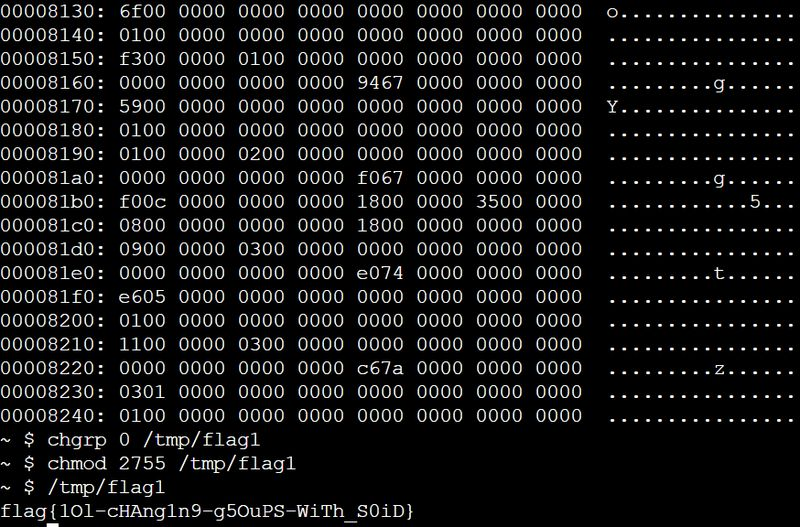